INFO: run with conda environment sc-mar2021

29.04.2022

Single-cell RNA-seq analysis - Pseudobulk counts

In [1]:
import os
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

In [4]:
sys.path.insert(0,'../..')
import paths_downsampling as paths
p = paths.get_paths()
print(p)
workdir = p['basedir'] + 'scripts/RNA/08_DEanalysis/DESeq2_RELN/'

{'basedir': '/psycl/g/mpsagbinder/mgp/workspace/SingleNuc_PostmortemBrain/', 'rawdir_RNA': '/psycl/g/mpsngs/HiSeq_Helmholtz/20210324_Anna_Froehlich_10X_RNAseq/03_downsampled/', 'figdir': '/psycl/g/mpsagbinder/mgp/workspace/SingleNuc_PostmortemBrain/figures/', 'writedir': '/psycl/g/mpsagbinder/mgp/workspace/SingleNuc_PostmortemBrain/scanpy_adata/', 'allendir': '/psycl/g/mpsagbinder/mgp/workspace/SingleNuc_PostmortemBrain/reference_data/allen_human/'}


## 1. Load data

### Load RNA-seq data with celltype labels

In [5]:
# switch from Anna_celltypes to ctAnna_r1 because the celltypes were inconsistent with clusters
ct_column = "ctAnna_r1"
#ct_column = "Anna_celltypes"

In [6]:
adata = sc.read(p['writedir']+'adata_labelTransfer_celltypes_samplesFilt_AnnaAnnotation_RELN.h5ad')

In [7]:
adata

AnnData object with n_obs × n_vars = 813095 × 26195
    obs: 'sample', 'individual', 'region', 'experiment', 'batch', 'SU.Number', 'Age', 'AgeBin', 'Sex', 'Ethnic.origin', 'Status', 'Classification', 'Classification.detail', 'Trauma.Code', 'Trauma.notes.medical.history', 'PMI', 'Hemisphere', 'Brain.pH', 'RIN', 'Chlorpromazine.equivalent', 'Antidepressants', 'Mode.of.death', 'Manner.of.Death', 'Suicide', 'COD.category', 'positive.Toxicology', 'Antipsychotics', 'Duration.of.psych.illness', 'Antipsychotics.meds.pres', 'Smoking.status', 'Freezer.storage.time..days.', 'alcohol.intake..g.day.past.12.mth.', 'Age.of.onset', 'Agonal.score', 'Main.Batch', '6-Batch', 'Position', 'Group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_counts', 'n_genes', 'dd_doublet', '

In [8]:
adata.var['gene_ids'].to_csv(workdir+'data/geneIDs_pseudocounts.csv')

In [9]:
print(adata.layers["counts"])

  (0, 37)	1.0
  (0, 154)	2.0
  (0, 156)	1.0
  (0, 195)	1.0
  (0, 227)	2.0
  (0, 369)	1.0
  (0, 374)	1.0
  (0, 381)	1.0
  (0, 441)	1.0
  (0, 575)	1.0
  (0, 611)	1.0
  (0, 707)	1.0
  (0, 714)	1.0
  (0, 724)	2.0
  (0, 780)	1.0
  (0, 808)	1.0
  (0, 825)	1.0
  (0, 844)	1.0
  (0, 910)	1.0
  (0, 914)	1.0
  (0, 932)	5.0
  (0, 934)	2.0
  (0, 958)	1.0
  (0, 962)	1.0
  (0, 973)	2.0
  :	:
  (813094, 25394)	1.0
  (813094, 25464)	2.0
  (813094, 25479)	1.0
  (813094, 25524)	1.0
  (813094, 25537)	1.0
  (813094, 25542)	1.0
  (813094, 25605)	1.0
  (813094, 25649)	1.0
  (813094, 25664)	1.0
  (813094, 25668)	1.0
  (813094, 25697)	1.0
  (813094, 25735)	1.0
  (813094, 25753)	1.0
  (813094, 25764)	2.0
  (813094, 25816)	1.0
  (813094, 25918)	2.0
  (813094, 25920)	1.0
  (813094, 26041)	1.0
  (813094, 26059)	1.0
  (813094, 26062)	4.0
  (813094, 26097)	1.0
  (813094, 26159)	1.0
  (813094, 26161)	2.0
  (813094, 26172)	1.0
  (813094, 26174)	1.0


### Remove cluster Exc_20 and Exc_7 from dataset

In [10]:
adata = adata[adata.obs[ct_column] != 'Exc_7']
adata = adata[adata.obs[ct_column] != 'Exc_20']
adata

View of AnnData object with n_obs × n_vars = 787046 × 26195
    obs: 'sample', 'individual', 'region', 'experiment', 'batch', 'SU.Number', 'Age', 'AgeBin', 'Sex', 'Ethnic.origin', 'Status', 'Classification', 'Classification.detail', 'Trauma.Code', 'Trauma.notes.medical.history', 'PMI', 'Hemisphere', 'Brain.pH', 'RIN', 'Chlorpromazine.equivalent', 'Antidepressants', 'Mode.of.death', 'Manner.of.Death', 'Suicide', 'COD.category', 'positive.Toxicology', 'Antipsychotics', 'Duration.of.psych.illness', 'Antipsychotics.meds.pres', 'Smoking.status', 'Freezer.storage.time..days.', 'alcohol.intake..g.day.past.12.mth.', 'Age.of.onset', 'Agonal.score', 'Main.Batch', '6-Batch', 'Position', 'Group', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_counts', 'n_genes', 'dd_dou

### Inspect number of cells per sample/celltype combination

In [11]:
cells_cross = pd.crosstab(adata.obs[ct_column],adata.obs["sample"])
cells_cross

sample,SU255_PFC_RNA,SU294_PFC_RNA,SU306_PFC_RNA,SU308_PFC_RNA,SU319_PFC_RNA,SU323_PFC_RNA,SU331_PFC_RNA,SU333_PFC_RNA,SU338_PFC_RNA,SU339_PFC_RNA,...,SU795_PFC_RNA,SU799_PFC_RNA,SU804_PFC_RNA,SU808_PFC_RNA,SU816_PFC_RNA,SU817_PFC_RNA,SU826_PFC_RNA,SU828_PFC_RNA,SU847_PFC_RNA,SU854_PFC_RNA
ctAnna_r1,,,,,,,,,,,,,,,,,,,,,
Astro_FB,605,375,437,252,408,432,460,182,47,186,...,224,379,377,687,329,318,591,384,441,21
Astro_PP,2145,1152,1430,1026,1728,1038,1173,1644,110,1436,...,815,806,1028,1771,821,1315,1200,1266,1574,555
Endothelial,373,203,108,192,100,134,111,68,71,111,...,104,293,290,299,290,266,225,158,144,109
Exc_L2-3,3107,3395,2348,2131,1138,2260,1914,1396,1506,2032,...,2581,2110,2945,3499,2915,3364,2103,2365,2871,549
Exc_L3-5,192,65,217,48,98,59,129,8,31,245,...,149,149,123,213,247,159,173,120,220,72
Exc_L4-6_1,728,368,765,202,345,363,275,519,323,946,...,390,478,284,491,458,219,443,373,661,258
Exc_L4-6_2,605,340,596,208,328,266,299,162,152,819,...,481,479,329,555,395,210,481,416,738,325
Exc_L4-6_3,280,186,431,23,57,63,201,61,116,618,...,35,353,96,188,130,34,284,160,290,96
Exc_L5-6,93,108,293,10,41,42,164,37,55,375,...,3,239,31,108,32,7,120,82,196,21


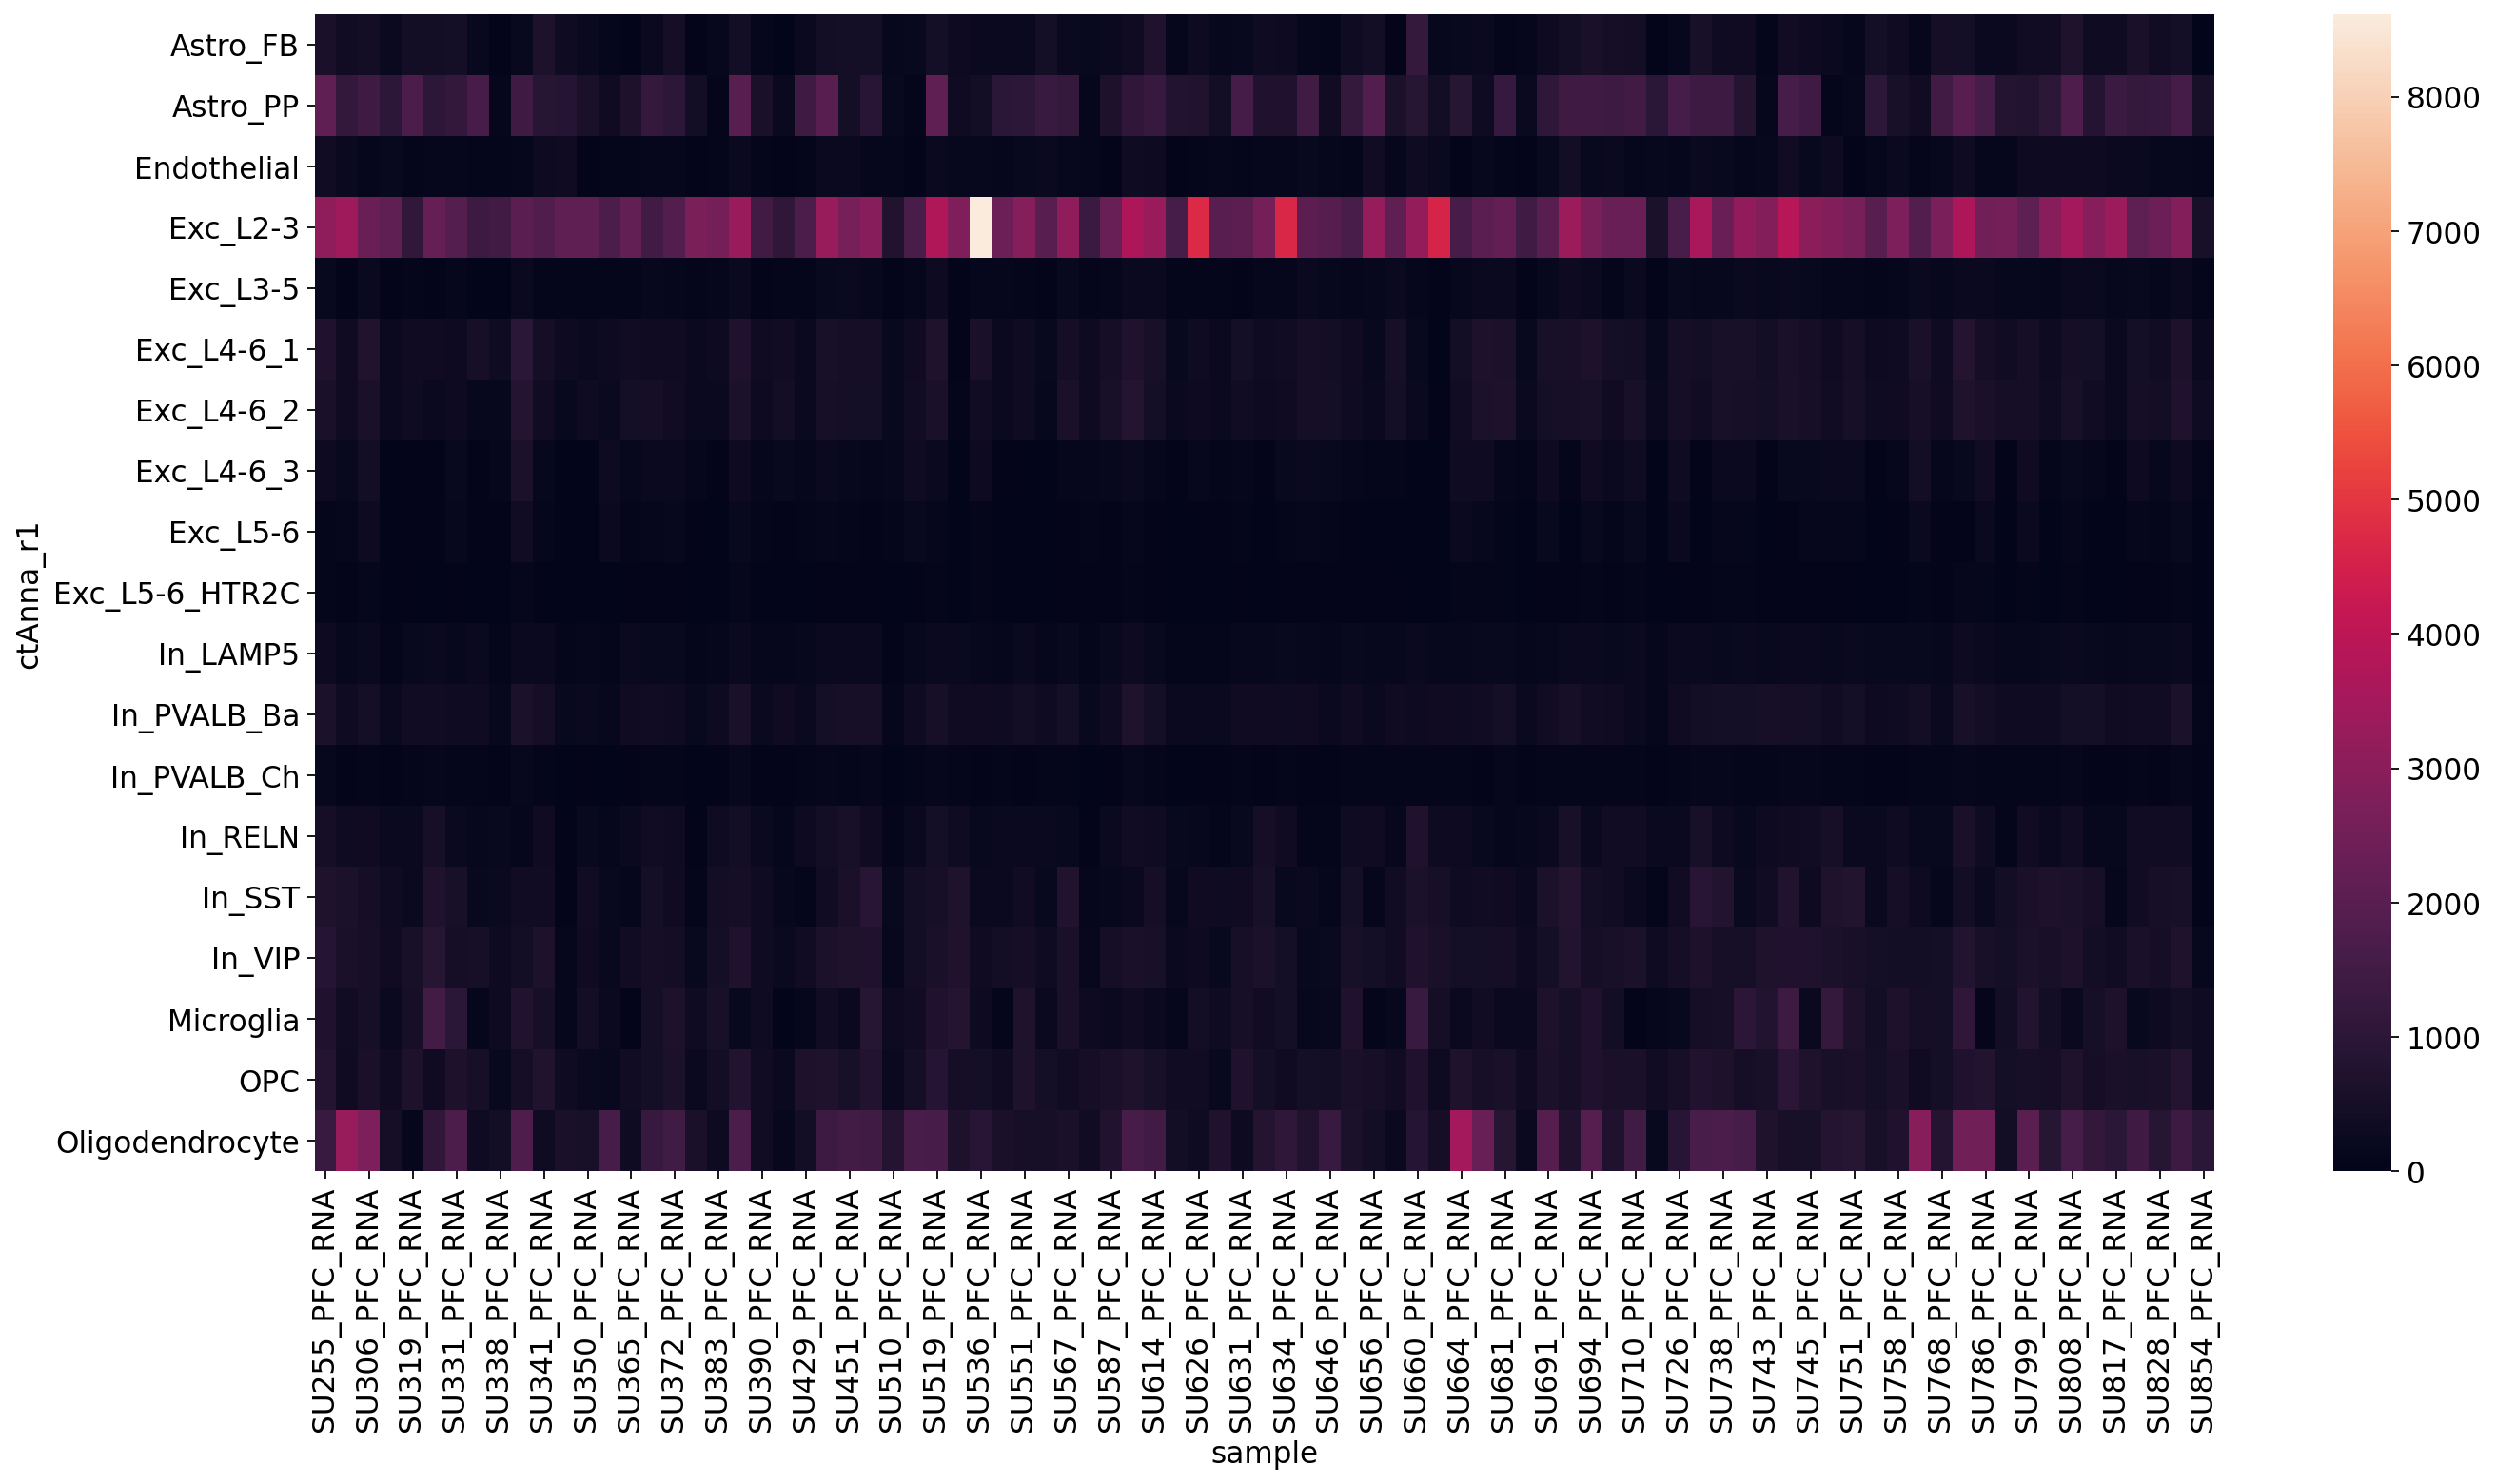

In [12]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sb.heatmap(cells_cross)

In [13]:
# count number of cells per celltype
ct_counts = adata.obs[ct_column].value_counts()
ct_counts

Exc_L2-3           218679
Oligodendrocyte     92744
Astro_PP            86351
OPC                 45427
In_VIP              42154
Microglia           39433
Exc_L4-6_1          36166
Exc_L4-6_2          35090
In_SST              34069
In_PVALB_Ba         31504
Astro_FB            26789
In_RELN             24095
In_LAMP5            15116
Exc_L4-6_3          14479
Endothelial         14353
Exc_L3-5            12152
Exc_L5-6             7564
In_PVALB_Ch          6717
Exc_L5-6_HTR2C       4164
Name: ctAnna_r1, dtype: int64

## 2. Generate group variable assigning cells to pseudosample

In [14]:
adata.obs["group"] = adata.obs[ct_column].astype(str) + "__" + adata.obs["sample"].astype(str)
adata.obs["group"] = adata.obs["group"].astype('category')
group_df = adata.obs['group']
group_df = group_df.reset_index(level=0)
group_df

,index,group
0,AAACCCACAATCTCTT-1-0-0,Oligodendrocyte__SU664_PFC_RNA
1,AAACCCAGTAGCTAAA-1-0-0,In_PVALB_Ba__SU664_PFC_RNA
2,AAACCCAGTATCGCGC-1-0-0,Exc_L4-6_3__SU664_PFC_RNA
3,AAACCCATCGTAGGAG-1-0-0,Exc_L2-3__SU664_PFC_RNA
4,AAACCCATCTGAACGT-1-0-0,Oligodendrocyte__SU664_PFC_RNA
...,...,...
787041,TTTGTTGGTCCGAAGA-1-91-90,Exc_L2-3__SU808_PFC_RNA
787042,TTTGTTGGTGTCTTCC-1-91-90,In_RELN__SU808_PFC_RNA
787043,TTTGTTGGTTAGGCTT-1-91-90,Astro_FB__SU808_PFC_RNA
787044,TTTGTTGTCAGCTTCC-1-91-90,Astro_PP__SU808_PFC_RNA


In [15]:
# sort cells so that cells of the same pseudosample are together
group_df.sort_values(by=['group'], inplace=True)
group_df

,index,group
672583,AGGGTTTGTATGCAAA-1-81-80,Astro_FB__SU255_PFC_RNA
673200,ATCGGATCATACAGGG-1-81-80,Astro_FB__SU255_PFC_RNA
681486,TCATATCGTTTGTGGT-1-81-80,Astro_FB__SU255_PFC_RNA
673224,ATCGTAGCAGCCTACG-1-81-80,Astro_FB__SU255_PFC_RNA
673266,ATCTCTACAGCGAACA-1-81-80,Astro_FB__SU255_PFC_RNA
...,...,...
642712,CATCAAGGTATCCTTT-1-76-75,Oligodendrocyte__SU854_PFC_RNA
644400,GTTATGGCAGCTCCTT-1-76-75,Oligodendrocyte__SU854_PFC_RNA
642714,CATCCACAGAATGTTG-1-76-75,Oligodendrocyte__SU854_PFC_RNA
644408,GTTCCGTAGGGCCAAT-1-76-75,Oligodendrocyte__SU854_PFC_RNA


In [16]:
#group_df.index.tolist()

In [17]:
type(adata.layers["counts"])

scipy.sparse.csr.csr_matrix

In [18]:
# sort count matrix according to previously identified order
mtx = adata.layers['counts'][group_df.index.tolist(),:]

In [19]:
print(mtx)

  (0, 109)	1.0
  (0, 135)	1.0
  (0, 144)	1.0
  (0, 154)	1.0
  (0, 156)	2.0
  (0, 169)	1.0
  (0, 176)	2.0
  (0, 202)	1.0
  (0, 227)	4.0
  (0, 262)	1.0
  (0, 308)	2.0
  (0, 318)	1.0
  (0, 459)	1.0
  (0, 488)	1.0
  (0, 566)	1.0
  (0, 582)	1.0
  (0, 674)	1.0
  (0, 704)	1.0
  (0, 707)	1.0
  (0, 714)	1.0
  (0, 726)	1.0
  (0, 737)	1.0
  (0, 788)	1.0
  (0, 825)	1.0
  (0, 875)	1.0
  :	:
  (787045, 25422)	1.0
  (787045, 25487)	7.0
  (787045, 25517)	2.0
  (787045, 25524)	1.0
  (787045, 25538)	1.0
  (787045, 25542)	1.0
  (787045, 25623)	1.0
  (787045, 25625)	1.0
  (787045, 25650)	1.0
  (787045, 25698)	1.0
  (787045, 25746)	1.0
  (787045, 25747)	3.0
  (787045, 25762)	1.0
  (787045, 25816)	1.0
  (787045, 26032)	1.0
  (787045, 26059)	2.0
  (787045, 26089)	1.0
  (787045, 26090)	1.0
  (787045, 26172)	2.0
  (787045, 26175)	4.0
  (787045, 26176)	1.0
  (787045, 26177)	3.0
  (787045, 26178)	1.0
  (787045, 26179)	6.0
  (787045, 26181)	2.0


In [20]:
# count the number of cells per pseudosample/group
group_counts = group_df['group'].value_counts()
group_counts = group_counts.rename_axis('group').reset_index(name='counts')
group_counts.sort_values(by=['group'], inplace=True)
group_counts

,group,counts
320,Astro_FB__SU255_PFC_RNA,605
657,Astro_FB__SU294_PFC_RNA,375
540,Astro_FB__SU306_PFC_RNA,437
889,Astro_FB__SU308_PFC_RNA,252
583,Astro_FB__SU319_PFC_RNA,408
...,...,...
176,Oligodendrocyte__SU817_PFC_RNA,947
129,Oligodendrocyte__SU826_PFC_RNA,1415
186,Oligodendrocyte__SU828_PFC_RNA,895
132,Oligodendrocyte__SU847_PFC_RNA,1402


In [21]:
# add columns necessary for the indices
tmp = np.add.accumulate(group_counts['counts'])
tmp
group_counts['sum'] = tmp-1
group_counts['sum_plus_one'] = tmp
group_counts

,group,counts,sum,sum_plus_one
320,Astro_FB__SU255_PFC_RNA,605,604,605
657,Astro_FB__SU294_PFC_RNA,375,979,980
540,Astro_FB__SU306_PFC_RNA,437,1416,1417
889,Astro_FB__SU308_PFC_RNA,252,1668,1669
583,Astro_FB__SU319_PFC_RNA,408,2076,2077
...,...,...,...,...
176,Oligodendrocyte__SU817_PFC_RNA,947,782368,782369
129,Oligodendrocyte__SU826_PFC_RNA,1415,783783,783784
186,Oligodendrocyte__SU828_PFC_RNA,895,784678,784679
132,Oligodendrocyte__SU847_PFC_RNA,1402,786080,786081


In [22]:
# get the indices necessary for the accumulation of counts
#indices = np.zeros(2 * len(group_counts))
#print(len(indices))
#indices[1::2] = group_counts['sum']
#indices[2::2] = group_counts['sum_plus_one'][:-1]
#indices = indices.astype(int).tolist()

In [23]:
# get the indices necessary for the accumulation of counts
indices = np.zeros(len(group_counts))
print(len(indices))
indices[1:] = group_counts['sum_plus_one'][:-1]
indices = indices.astype(int).tolist()

1648


In [24]:
indices[-10:]

[775318,
 775727,
 777766,
 778663,
 780266,
 781422,
 782369,
 783784,
 784679,
 786081]

In [25]:
indices[0:10]

[0, 605, 980, 1417, 1669, 2077, 2509, 2969, 3151, 3198]

In [26]:
# accumulate counts per group/pseudosample
pseudocounts = np.add.reduceat(mtx.toarray(),indices)

In [27]:
pseudocounts.shape

(1648, 26195)

In [28]:
mtx.toarray()[1:20,1:20]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.

In [29]:
mtx[0:566,0]

<566x1 sparse matrix of type '<class 'numpy.float32'>'
	with 0 stored elements in Compressed Sparse Row format>

In [30]:
mtx[0:566,0].sum(axis=0)

matrix([[0.]], dtype=float32)

In [31]:
pseudocounts[0:3,0:20]

array([[ 0.,  9.,  8., 13.,  1.,  0.,  5.,  1.,  3., 20., 16.,  6.,  0.,
         0.,  5., 54.,  9.,  0.,  9., 38.],
       [ 0.,  0.,  8.,  9.,  0.,  0.,  1.,  0.,  5., 13.,  8.,  2.,  0.,
         0.,  0., 30.,  5.,  0.,  7., 22.],
       [ 1.,  2.,  4.,  8.,  0.,  0.,  0.,  3.,  4.,  3., 18.,  1.,  0.,
         0.,  1., 13.,  6.,  0.,  6., 19.]], dtype=float32)

In [32]:
pseudocounts[-3:,-20:]

array([[7.790e+02, 4.600e+01, 3.410e+02, 4.720e+02, 4.430e+02, 1.080e+02,
        4.690e+02, 1.460e+02, 6.000e+00, 3.320e+02, 2.000e+00, 0.000e+00,
        8.000e+00, 0.000e+00, 1.600e+01, 3.400e+01, 7.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00],
       [1.670e+03, 3.230e+02, 1.246e+03, 1.095e+03, 1.351e+03, 2.920e+02,
        1.298e+03, 3.310e+02, 1.300e+01, 8.060e+02, 0.000e+00, 0.000e+00,
        1.400e+01, 2.000e+00, 2.800e+01, 8.900e+01, 5.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00],
       [4.278e+03, 3.330e+02, 2.576e+03, 1.800e+03, 6.610e+03, 8.440e+02,
        2.408e+03, 6.020e+02, 8.000e+00, 1.294e+03, 2.000e+00, 3.000e+00,
        1.000e+01, 1.100e+01, 1.900e+01, 1.790e+02, 2.400e+01, 1.000e+00,
        6.000e+00, 1.000e+00]], dtype=float32)

In [33]:
np.savetxt(workdir + 'data/pseudocounts.csv', pseudocounts, delimiter=',')

In [34]:
group_df.to_csv(workdir + 'data/group_assignment_pseudocounts.csv')

In [35]:
group_counts[['group','counts']].to_csv(workdir + 'data/pseudosamples.csv')